In [86]:
import os
import numpy as np
import tqdm

import torch
from torch import nn

from ptgprocess.clip import ZeroClip, ActionClip1, ActionClip2
from ptgprocess.util import video_feed, draw_text_list
import ptgctl

In [5]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(24, 6))

In [120]:
# model = ZeroClip()
model = ActionClip2()

In [121]:
api = ptgctl.API()
api

In [66]:
text_group_name = 'pinwheels'
text_group_name = 'coffee'
recipe = api.recipes.get(text_group_name)
recipe

request: GET https://api.ptg.poly.edu/recipes/pinwheels
200 took 0.121 secs


{'_id': 'pinwheels',
 'name': 'Pinwheels',
 'ingredients': ['1 8-inch flour tortilla',
  'Jar of nut butter or allergy-friendly alternative (such as sunbutter, soy butter, or seed butter)',
  'Jar of jelly, jam, or fruit preserves'],
 'tools': ['cutting board',
  'butter knife',
  'paper towel',
  'toothpicks',
  '~12-inch strand of dental floss',
  'plate'],
 'instructions': ['Place tortilla on cutting board.',
  'Use a butter knife to scoop nut butter from the jar. Spread nut butter onto tortilla, leaving 1/2-inch uncovered at the edges.',
  'Clean the knife by wiping with a paper towel.',
  'Use the knife to scoop jelly from the jar. Spread jelly over the nut butter.',
  'Clean the knife by wiping with a paper towel.',
  'Roll the tortilla from one end to the other into a log shape, about 1.5 inches thick. Roll it tight enough to prevent gaps, but not so tight that the filling leaks.',
  'Secure the rolled tortilla by inserting 5 toothpicks about 1 inch apart.',
  'Trim the ends of 

In [84]:
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

In [87]:

ann_root = '/opt/Github/epic-kitchens-100-annotations-normalized'
normalized = True
df = pd.concat([
    pd.read_csv(os.path.join(ann_root, f"EPIC_100_train{'_normalized' if normalized else ''}.csv")).assign(split='train'),
    pd.read_csv(os.path.join(ann_root, f"EPIC_100_validation{'_normalized' if normalized else ''}.csv")).assign(split='val'),
])
ann_videos = df.video_id.unique()
print(df.shape)
df.head()

(76885, 25)


,Unnamed: 0,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes,gen_verb,gen_noun,gen_verb_noun,norm_verb,norm_verb_prep,norm_noun,norm_verb_noun,norm_verb_prep_noun,split
0,0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3],open,door,open door,open,open,cupboard,open cupboard,open cupboard,train
1,1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114],turn-on,light,turn-on light,turn-on,turn-on,light,turn-on light,turn-on light,train
2,2,P01_01_10,P01,P01_01,00:00:23.340,00:00:24.97,00:00:26.20,1498,1572,open drawer,open,3,drawer,8,['drawer'],[8],open,drawer,open drawer,open,open,drawer,open drawer,open drawer,train
3,3,P01_01_100,P01,P01_01,00:07:57.919,00:07:59.75,00:08:00.88,28785,28852,take cup,take,0,cup,13,['cup'],[13],take,cup,take cup,take,take,cup,take cup,take cup,train
4,4,P01_01_101,P01,P01_01,00:08:00.020,00:08:01.47,00:08:02.21,28888,28932,open cupboard,open,3,cupboard,3,['cupboard'],[3],open,cupboard,open cupboard,open,open,cupboard,open cupboard,open cupboard,train


In [88]:
df.groupby('split').apply(lambda d: d.groupby('participant_id').apply(lambda di: di.video_id.unique().tolist()))

split  participant_id
train  P01               [P01_01, P01_02, P01_03, P01_04, P01_05, P01_0...
       P02               [P02_01, P02_02, P02_03, P02_04, P02_05, P02_0...
       P03               [P03_02, P03_03, P03_04, P03_05, P03_06, P03_0...
       P04               [P04_01, P04_02, P04_03, P04_04, P04_05, P04_0...
       P05               [P05_01, P05_02, P05_03, P05_04, P05_05, P05_0...
       P06               [P06_01, P06_02, P06_03, P06_05, P06_07, P06_0...
       P07               [P07_01, P07_02, P07_03, P07_04, P07_05, P07_0...
       P08               [P08_01, P08_02, P08_03, P08_04, P08_05, P08_0...
       P09               [P09_01, P09_02, P09_03, P09_04, P09_05, P09_0...
       P10                                        [P10_01, P10_02, P10_04]
       P11               [P11_01, P11_02, P11_03, P11_04, P11_05, P11_0...
       P12               [P12_01, P12_02, P12_04, P12_05, P12_06, P12_0...
       P13               [P13_04, P13_05, P13_06, P13_07, P13_08, P13_0...
   

In [90]:
df[df.split == 'val'].groupby('video_id').narration_id.count()

video_id
P01_11    148
P01_12     62
P01_13     30
P01_14    354
P01_15    291
P02_12    371
P02_13     14
P02_14     14
P02_15     50
P03_21     13
P03_22     26
P03_23    125
P03_24    136
P03_25     16
P03_26      4
P04_24     64
P04_25     27
P04_26      3
P04_27     11
P04_28     25
P04_29     61
P04_30     50
P04_31    113
P04_32      7
P04_33     21
P05_07    111
P05_09     66
P06_10     60
P06_11     23
P06_12     30
P06_13     63
P06_14     32
P07_12     43
P07_13     15
P07_14     43
P07_15     17
P07_16     29
P07_17     26
P07_18     14
P08_09    147
P08_10     63
P08_14     43
P08_15    133
P08_16    120
P08_17    120
P09_07     17
P09_08     27
P10_03    235
P11_17    147
P11_18     18
P11_19     34
P11_20    195
P11_21     11
P11_22     73
P11_23     21
P11_24     24
P12_03    111
P12_08     26
P13_01     49
P13_02     10
P13_03     48
P14_06     13
P14_08     33
P15_04     37
P15_05     14
P15_06     64
P16_04     57
P17_02     27
P18_01     43
P18_02     27
P18_03    1

In [91]:
ls ~/Desktop/scratch.nosync/videos/

P01_13.MP4  P03_26.MP4* P04_27.MP4* P07_18.MP4  P08_17.MP4


In [122]:
# video_fname = '/Users/beasteers/Desktop/scratch.nosync/2022.07.26-20.35.03-main.mp4'
# video_fname = '/Users/beasteers/Desktop/scratch.nosync/coffee-test-1-main.mp4'
video_fname = '~/Desktop/scratch.nosync/videos/P01_13.MP4'
video_fname = os.path.expanduser(video_fname)
os.path.isfile(video_fname)

True

In [123]:
video_name = os.path.splitext(os.path.basename(video_fname))[0]
out_dir = f'output/{video_name}-{model.__class__.__name__}'
os.makedirs(out_dir, exist_ok=True)
has_gt = video_name in ann_videos
out_dir, has_gt


('output/P01_13-ActionClip2', True)

In [124]:
df_vid = df[df.video_id == video_name]
texts = df_vid.narration.unique()
text_group_name = 'EK'
texts

array(['take cereal bag', 'fold cereal bag', 'hang table cloth',
       'take washing up liquid', 'pour washing op liquid',
       'put down washing up liquid', 'turn on tap', 'wash cup and spoon',
       'rinse spoon', 'put down spoon', 'rinse cup', 'turn off tap',
       'put cereal bag into cereal box', 'put down cup', 'dry hands',
       'open cupboard', 'take glass', 'close cupboard', 'put down glass',
       'take bottle', 'pour water into glass', 'drink water',
       'close cereal box', 'put cereal box into cupboard',
       'take cup and spoon', 'put down cup and spoon', 'take table cloth'],
      dtype=object)

In [125]:
# texts = recipe['steps']
with open(os.path.join(out_dir, 'actions.txt'), 'w') as f:
    f.write('\n'.join(texts))

Z_text = model.encode_text(texts).detach().numpy()
Z_text.shape

(27, 512)

In [126]:
import cv2

In [102]:
tqdm.tqdm._instances.clear()
fps = 10
ims = []
for t, im in video_feed(video_fname, fps=fps):
    if t > 180:
        break
    ims.append(cv2.resize(im, (760, 428)))
ims = np.stack(ims)
ims.shape

93.8 second video. 5620.0 frames @ 59.94005994005994 fps, reducing to 10 fps


t=93.4s: 100%|██████████| 5620/5620 [00:30<00:00, 186.11it/s]            


(1120, 428, 760, 3)

In [127]:
tqdm.tqdm._instances.clear()
Z_images = []
for im in tqdm.tqdm(ims):
    z_im = model.encode_image(im).detach()
    Z_images.append(z_im)
Z_images = np.concatenate(Z_images)
Z_images.shape

100%|██████████| 1120/1120 [02:28<00:00,  7.57it/s]


(1120, 512)

In [128]:
# Z_images = []
# for t, im in video_feed(video_fname, fps=5):
#     if t > 60:
#         break
#     z_im = model.encode_image(im)
#     Z_images.append(z_im)
# Z_images = torch.cat(Z_images).detach().numpy()
# Z_images.shape

In [211]:
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

tiangs = angle_between(Z_images,Z_text.T)
tiangs

array([[1.5687906, 1.5687145, 1.5691385, ..., 1.5692368, 1.5690526,
        1.5690509],
       [1.568754 , 1.5687083, 1.5691898, ..., 1.5692354, 1.5690894,
        1.5690728],
       [1.5687941, 1.5687602, 1.5692214, ..., 1.5692406, 1.5690751,
        1.5691078],
       ...,
       [1.5695261, 1.5697234, 1.5693239, ..., 1.5699947, 1.5700989,
        1.5691515],
       [1.5695645, 1.5697608, 1.5693105, ..., 1.5700165, 1.5701084,
        1.5691369],
       [1.5695827, 1.5697892, 1.5693079, ..., 1.5700448, 1.5701419,
        1.5691316]], dtype=float32)

In [251]:
Z_text.shape

(27, 512)

In [254]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA
# dimreduc = PCA(n_components=2)
dimreduc = LocallyLinearEmbedding(n_components=2)
#dimreduc = Isomap(n_components=2)
# dimreduc.fit(np.concatenate([Z_text, Z_images[np.random.choice(len(Z_text), size=len(Z_images))]]))
Zt_text = dimreduc.fit_transform(Z_text)
# Zt_text = dimreduc.transform(Z_text)

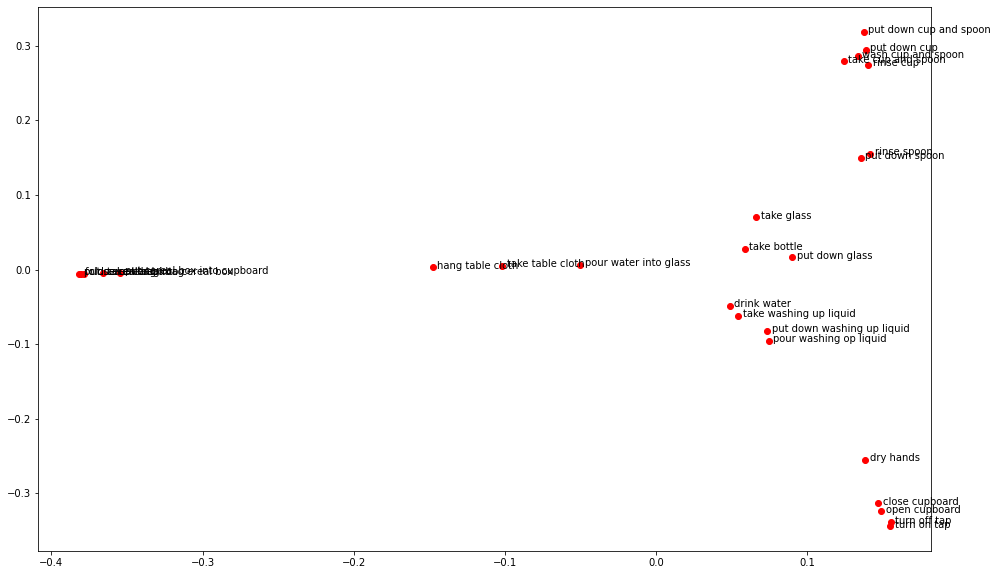

In [255]:
plt.figure(figsize=(16, 10))
plt.scatter(Zt_text[:,0], Zt_text[:,1], label='text', c='r')
ax=plt.gca()
for z, t in zip(Zt_text, texts):
    ax.annotate(t, (z[0]+0.003, z[1]-0.002))
plt.savefig(os.path.join(out_dir, 'text-space.jpg'))

In [256]:
Zt_images = dimreduc.transform(Z_images)
Zt_images.shape

(1120, 2)

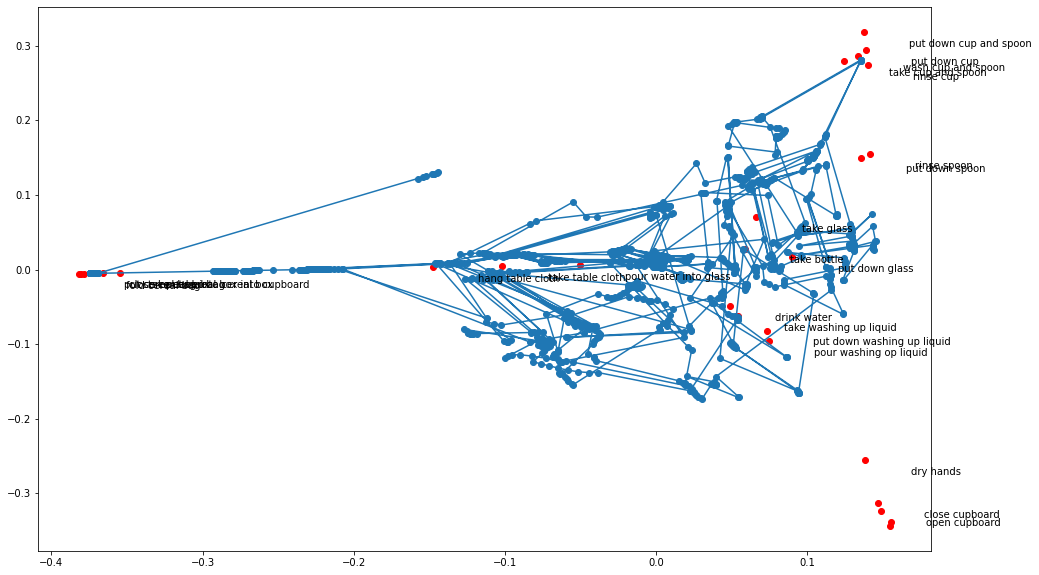

In [257]:
plt.figure(figsize=(16, 10))
plt.scatter(Zt_text[:,0], Zt_text[:,1], label='text', c='r')

ax=plt.gca()
for z, t in zip(Zt_text, texts):
    ax.annotate(t, (z[0]+0.03, z[1]-0.02))
# plt.legend()

plt.plot(Zt_images[:,0], Zt_images[:,1])
# plt.scatter(Zt_images[-1,0], Zt_images[-1,1],c='red', s=200)
plt.scatter(Zt_images[:,0], Zt_images[:,1])
plt.savefig(os.path.join(out_dir, 'text+image-space.jpg'))

In [272]:

import matplotlib.animation as pltanim
from IPython.display import Video, HTML
from adjustText import adjust_text

AttributeError: 'Annotation' object has no property 'avoid_points'

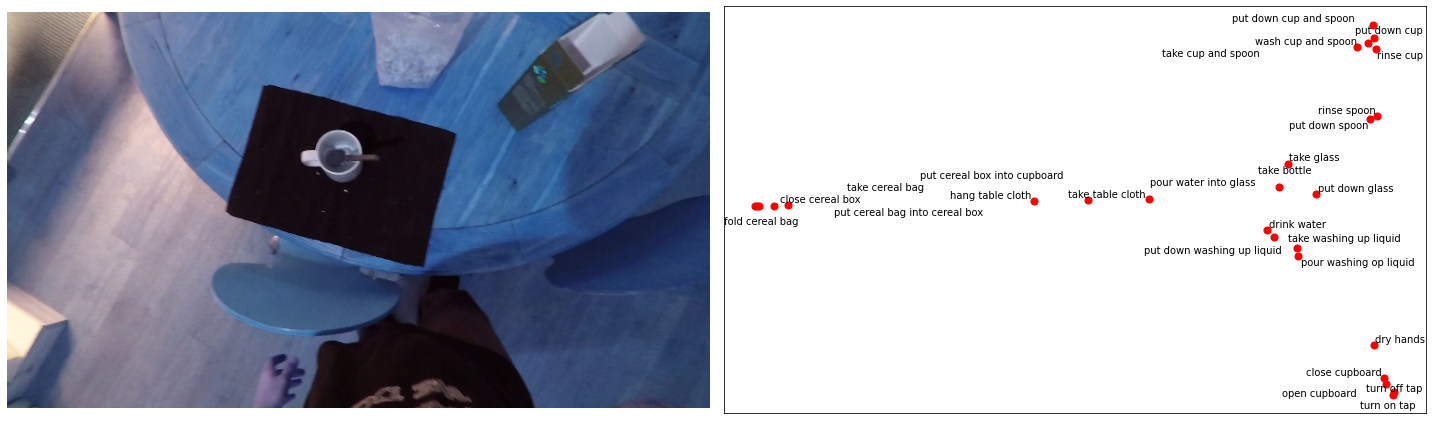

In [277]:
tqdm.tqdm._instances.clear()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.axis('off')
# ax2.xaxis.set_ticks_position('none')
# ax2.yaxis.set_ticks_position('none')
ax2.set_xticks([])
ax2.set_yticks([])
# ax2.axis('off')
plt.tight_layout()

imshowed = ax1.imshow(ims[0])

ax2.scatter(Zt_text[:,0], Zt_text[:,1], label='text', c='r', s=50)
text_annots = [ax2.annotate(t, (z[0], z[1])) for z, t in zip(Zt_text, texts)]
# text_annots = [ax2.text(z[0], z[1], t) for z, t in zip(Zt_text, texts)]
adjust_text(
    text_annots, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), 
    lim=50, avoid_self=False)

ax2.plot(Zt_images[:,0], Zt_images[:,1], c='k', alpha=0.1)
imscatter = ax2.scatter([], [], s=100)

topk = 5
lines_topk = [ax2.plot([], [], c='r')[0] for i in range(topk)]

def animate(frame):
    im = ims[frame].copy()

    similarity = torch.Tensor(100*Z_images[frame] @ Z_text.T).softmax(dim=-1)
    sim = similarity.detach().tolist()

    i_topkmax = torch.topk(similarity, topk, dim=-1)[1].detach().cpu().numpy().astype(int)
    pred_labels = [f'{texts[i]} ({sim[i]:.0%})' for i in i_topkmax]
    pred_text = [texts[i] for i in i_topkmax]

    i=0
    if has_gt:
        dft = df_vid[(df_vid.start_frame/60 < frame/fps) & (df_vid.stop_frame/60 > frame/fps)]
        texts_true = list(dft.narration.unique())
        _, i = draw_text_list(im, [t for t in texts_true if t in pred_text[:1]], color=(0,255,0))
        _, i = draw_text_list(im, [t for t in texts_true if t in pred_text[1:]], i, color=(255,255,0))
        _, i = draw_text_list(im, [t for t in texts_true if t not in pred_text], i, color=(0,0,255))
    _, i = draw_text_list(im, pred_labels, i)

    zxy = Zt_images[frame:frame+1]
    imshowed.set_data(im[:,:,::-1])
    imscatter.set_offsets(zxy)

    for l, i in zip(lines_topk, i_topkmax):
        l.set_data([zxy[0, 0], Zt_text[i, 0]], [zxy[0, 1], Zt_text[i, 1]])
        l.set_alpha(sim[i])
    return [imshowed, imscatter] + lines_topk

def init():
    return animate(0)

ani = pltanim.FuncAnimation(
    fig, animate, tqdm.tqdm(np.arange(len(ims))[:50]), init_func=init, 
    interval=int(1000/fps), blit=True)

f=os.path.join(out_dir, 'emb-motion1.mp4')
ani.save(f, writer=pltanim.FFMpegWriter(fps=fps))
plt.close()
Video(f)

In [ ]:
Video(f)